# **Amazon Fine Food Review, Sentiment Analysis using Machine Learning technique KNN.**

About Database- All data in one sqlite database. 568,454 food reviews Amazon users left up to October 2012 Overview- 
1) In this project, we have 568k * 10 size dataset. i.e. 568k rows and 10 columns(features).

 2) In this dataset, we have 10 features which are as follows-
  i) Id-Row Id
 ii) ProductId- Unique identifier for the product iii) UserId- Unqiue identifier for the user 
 iv) ProfileName- Profile name of the user 
 v) HelpfulnessNumerator- Number of users who found the review helpful
 vi) HelpfulnessDenominator- Number of users who indicated whether they found the review helpful or not 
 vii) Score- Rating between 1 and 5 
 viii) Time- Timestamp for the review 
 ix) Summary- Brief summary of the review x) Text- Text of the review

 objective of this project is to predict whether given new review is positive or negative.

In [83]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_validate
from collections import Counter

In [84]:
# we will read data
con=sqlite3.connect('/content/drive/MyDrive/amazon/database.sqlite')

# we neglect the review having Score = 3
filtered_data=pd.read_sql_query(''' SELECT * FROM Reviews WHERE Score!=3''',con)

In [85]:
filtered_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [86]:
print(filtered_data.dtypes)
#filtered_data['Score']=filtered_data['Score'].astype(int)

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object


In [87]:
def partition(x):
  if x< 3:
    return 'negetive'
  return 'positive'
#filtered_data['Score1']=filtered_data['Score'].map(lambda x : 'negetive' if x < '3' else 'positive')


In [88]:
actualscore=filtered_data['Score']
positivenegetive= actualscore.map(partition)
filtered_data['Score']=positivenegetive

In [89]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negetive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negetive,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [90]:
filtered_data['Score'].value_counts()

positive    443777
negetive     82037
Name: Score, dtype: int64

In [91]:

#  EDA

display=pd.read_sql_query(''' SELECT * FROM Reviews WHERE Score!=3 
                              AND UserId="AR5J8UI46CURR"
                              ORDER BY ProductID''',con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...



**Observations: **
1) As in above table, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator.Score,Time, Summary and Text shows same content 
2) Also for all 5 product, shows same time.
 3) Here we observed that, product is same, only the flavour is different
4) so we will remove this duplication and keep any one product which all these features so we removing duplicates.

In [92]:
 #we will sort data according to ProductId in ascending order#
sorted_data= filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [93]:
final=sorted_data.drop_duplicates(subset={'UserId', 'ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

In [94]:
#After removing duplications, we will see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [95]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)


Now, we do preprocessing like removal of stop words, html tags and make all letters in lowercase.

In [96]:
import re
i=0
for sent in final['Text'].values:
  if (len(re.findall('<.*?>',sent))):
    print(i)
    print(sent)
    break
  i+=1


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [97]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from  nltk.stem.wordnet import WordNetLemmatizer

In [98]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [99]:
stop=set(stopwords.words('english'))       #set of stopwords
sno=nltk.stem.SnowballStemmer('english')     # initialising snowball stemmer

In [100]:
def cleanhtml(sentence):     #function to clean word of any html tags
  cleanr=re.compile('<.*?>')
  cleantext=re.sub(cleanr,' ',sentence)
  return cleantext
def cleanpunc(sentence):
  cleaned=re.sub(r'[?|!|\'|"|#]',r'',sentence)
  cleaned=re.sub(r'[.|,|)|(|\|/)]',r' ',sentence)
  return cleaned


In [101]:
print(stop)
print(sno.stem('tasty'))

{'does', 'having', 'should', 'these', 'will', 'own', 'isn', "wasn't", 'o', 'ourselves', 'here', 'me', 'she', 'themselves', 'hadn', 'yours', "mustn't", 'for', 'just', 'each', 'over', 've', "aren't", 'ain', 'until', "didn't", 'we', 's', 'during', "don't", 'above', 'then', 'm', "needn't", 'yourself', 'do', 'more', "shan't", 'which', 'them', 'why', 'it', 'and', 'were', 'ours', 'what', 'in', "haven't", "isn't", 'there', 'myself', 'can', 'under', "you'd", 'if', 'to', 'i', 'once', "won't", 'll', 'himself', 'into', 'you', 'through', 'hasn', 'theirs', 'some', 'didn', 'from', 'this', 'all', 'with', 'they', 'up', 'nor', 't', 'is', 'has', 'of', 'doesn', 'shouldn', "shouldn't", 'same', 'those', 'haven', "you've", 'where', 'had', 'their', 'yourselves', 'now', 'being', "hasn't", "it's", 'whom', 'few', 'as', 'below', 'between', 'that', 'was', 'he', 'y', "wouldn't", "hadn't", 'don', 'shan', 'before', 'both', 'further', 'on', 'too', 'been', "you're", "couldn't", 'are', 'than', 'won', 'at', "you'll", "th

In [102]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

i=0
final_string=[]
all_postive_words=[]
all_negetive_words=[]

for sent in final['Text'].values:
  filtered_sentence=[]
  sent=cleanhtml(sent)
  for w in sent.split():
    for cleanword in cleanpunc(w).split():
      if ((cleanword.isalpha()) & (len(cleanword)>2)):
        if (cleanword.lower() not in stop):
          s=(sno.stem(cleanword.lower()))
          filtered_sentence.append(s)
          if (final['Score'].values)[i]=='positive':
            all_postive_words.append(s)
          if (final['Score'].values)[i]=='negetive':
            all_negetive_words.append(s)
        else:
          continue
      else:
        continue
  str1=' '.join(filtered_sentence)
  final_string.append(str1)
  i+=1



In [103]:
final['CleanText']=final_string

In [105]:
final.head(3)
# store final table into an SQlLite table for future.

con1=sqlite3.connect('final.sqlite')
c=con1.cursor()
final.to_sql('Reviews',con1,schema=None,index=True,index_label=None,chunksize=None,dtype=None)

In [106]:
import sqlite3
con=sqlite3.connect('final.sqlite')


In [107]:
cleaned_data=pd.read_sql_query('''SELECT * FROM Reviews''',con)
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month learn poem throug...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [108]:
cleaned_data.shape

(364171, 12)

In [109]:
data_p=cleaned_data[cleaned_data['Score']=='positive'].sample(n=5000)
data_n=cleaned_data[cleaned_data['Score']=='negetive'].sample(n=5000)
data=pd.concat([data_p,data_n])

In [110]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
149143,382423,413494,B0017M5V9A,A33QQ1S92XNB7V,D. Weitzler,7,10,positive,1250380800,For webbing clothes moths only,If you see the little sacks of the case making...,see littl sack case make cloth moth buy produc...
31507,34027,37028,B000ARTNRE,A2OIMJEGOCTQ87,Lisa,4,4,positive,1311206400,Good for a LACTOSE FREE formula,Our second daughter was having severe gas cram...,second daughter sever gas cramp would cri ate ...
114849,255169,276646,B000QF7KK2,A2AIB0TNI1FO5T,Condie,3,3,positive,1314057600,One Whiff Tells the Telli-,Open the package. Take a whiff. You'll never l...,open packag take whiff never look smell aroma ...
79153,499338,539890,B000H221Z8,A2OQUXSK2Y7TPS,Paul Chung Min Ha,2,2,positive,1172534400,the best ramen out there,These ramen noodles are the best in the whole ...,ramen noodl best whole korean colleg student e...
7286,191610,207747,B00012182G,A1G2G1WHEW02TY,"Jeremy Cott ""Cott""",46,59,positive,1265241600,Scary,"BEWARE! I recieved my rabbit today, and it was...",reciev rabbit today aliv foul cruel rodent eve...


In [111]:
data.shape

(10000, 12)

In [112]:
data['Time']=pd.to_datetime(data['Time'],unit='s')
data=data.sort_values(by='Time')

In [113]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
1030,443669,479730,B00005U2FA,A7BP01VQO33U,Caleb,11,11,positive,2002-05-23,Way To Go Guys!,I'm never dissapointed with the great gadgets ...,never dissapoint great gadget compani come bro...
4237,175209,190013,B0000DGG1U,A28SJYEFR84MU1,L Flores,18,18,positive,2004-01-20,Beautiful!,I received this tree only 3 days after I order...,receiv tree day order nice fat trunk look exac...
2429,511011,552536,B0000CCZYY,A32W5JY028CB9E,A. Mickelson,3,3,positive,2004-07-24,You have not had Licorice until you've had Panda,"I am a huge black licorice fan, however I don'...",huge black licoric fan howev think realli expe...
10971,156041,169237,B0001ES9FI,A15GIGNO8UUR9E,Henny de Gruijter,10,12,positive,2004-08-05,Why not in Canada ?,"Going on a regular basis to Holland, I got to ...",go regular basi holland got know philip senseo...
5203,157524,170815,B0000EIEWO,A3UU7SZXSZ2ZSB,David J. Dodson,9,12,negetive,2004-09-09,Good pears... bad service,I recently placed an order from this company a...,recent place order compani disappoint paid ext...


## **BOW**

In [114]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
# Fuction to compute k value
def k_classifier_brute(X_train, y_train):
    # creating odd list of K for KNN
    myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k

In [115]:
## 7k data which will use to train model after vectorization
X= data['CleanText']
y=data['Score']
print(X.shape,y.shape)

(10000,) (10000,)


In [116]:
#Splitting data in to 70% Train % Test

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(7000,) (7000,) (3000,) (3000,)


In [117]:
# Train Vectorizor

from sklearn.feature_extraction.text import CountVectorizer
bow=CountVectorizer()
X_train=bow.fit_transform(X_train)


In [118]:
X_test=bow.transform(X_test)


In [119]:
print(X_test.shape)

(3000, 10943)



The optimal number of neighbors is 39.


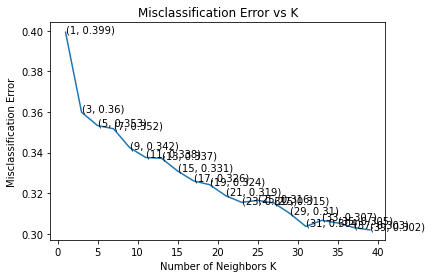

the misclassification error for each k value is :  [0.399 0.36  0.353 0.352 0.342 0.338 0.337 0.331 0.326 0.324 0.319 0.315
 0.316 0.315 0.31  0.304 0.307 0.305 0.303 0.302]


39

In [120]:
from sklearn.metrics import accuracy_score
optimal_k_bow= k_classifier_brute(X_train,y_train)
optimal_k_bow

In [121]:
# instantiate learning model k = optimal_k

knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k_bow)

#fitting the model
knn_optimal.fit(X_train,y_train)

#Predict respondse
pred=knn_optimal.predict(X_test)

In [122]:
#Accuracy on Train data
train_acc_bow=knn_optimal.score(X_train,y_train)
print('Train accuracy',train_acc_bow)

train_err_bow=1-train_acc_bow
print('Train error is ',train_err_bow)

Train accuracy 0.7467142857142857
Train error is  0.25328571428571434


In [123]:
#Evaluate accuracy on test data

acc_bow=accuracy_score(y_test,pred)*100
print('The accuracy of KNN classifier k={}, accuracy={}'.format(optimal_k_bow,acc_bow))

The accuracy of KNN classifier k=39, accuracy=69.16666666666667


In [124]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 898,  542],
       [ 383, 1177]])

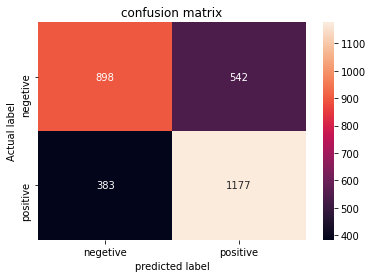

In [125]:
import seaborn as sns
class_label=['negetive','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title('confusion matrix')
plt.xlabel('predicted label')
plt.ylabel('Actual label')
plt.show()

In [126]:
df_cm

,negetive,positive
negetive,898,542
positive,383,1177


In [127]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))


              precision    recall  f1-score   support

    negetive       0.70      0.62      0.66      1440
    positive       0.68      0.75      0.72      1560

    accuracy                           0.69      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.69      0.69      0.69      3000




**Observations:**

1) From above figure(misclassification error vs optimal k),
 it is showing that classification error for each value of k, when k is increaseing the error is decreasing.            
 2) For example, if k = 1, error is 37%, k = 2, error is 34% and so on.
 3) As I tested our model on unseen data(test data) the accuracy is 68.53 when k = 33           
 4) In confusion matrix, It is clear that out of 3k unseen data-points classifier predict 1532 positive and 942 negative class label but in realilty there were 1517 positive and 1483 were negative.             
 5) So we can say the generalization error is quite high thats why this model does not work well with unseen data.

## TF-**IDF**

In [269]:
X= data['CleanText']
y=data['Score']
print(X.shape,y.shape)

(10000,) (10000,)


In [270]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [271]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec=TfidfVectorizer()
X_train=tf_idf_vec.fit_transform(X_train)
X_train

<7000x10943 sparse matrix of type '<class 'numpy.float64'>'
	with 212454 stored elements in Compressed Sparse Row format>

In [272]:
X_test=tf_idf_vec.transform(X_test)
X_test

<3000x10943 sparse matrix of type '<class 'numpy.float64'>'
	with 89826 stored elements in Compressed Sparse Row format>


The optimal number of neighbors is 39.


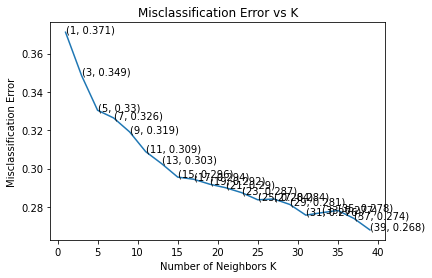

the misclassification error for each k value is :  [0.371 0.349 0.33  0.326 0.319 0.309 0.303 0.296 0.294 0.292 0.29  0.287
 0.284 0.284 0.281 0.276 0.277 0.278 0.274 0.268]


39

In [273]:
#choosing optimal_k
optimal_k_tfidf=k_classifier_brute(X_train,y_train)
optimal_k_tfidf

In [274]:
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k_tfidf)

#Fitting model
knn_optimal.fit(X_train,y_train)

#predict response
pred=knn_optimal.predict(X_test)


In [275]:
train_acctfidf=knn_optimal.score(X_train,y_train)
print('Train accuracy',train_acctfidf)

train_err_tfidf=1-train_acctfidf
print('train error tfiddf',train_err_tfidf)

Train accuracy 0.7584285714285715
train error tfiddf 0.24157142857142855


In [276]:
#Evaluating accuracy

acc_tfidf=accuracy_score(y_test,pred)*100
print('The accuracy of knn classifier for k = {}, and accuracy={}'.format(optimal_k_tfidf,acc_tfidf))

The accuracy of knn classifier for k = 39, and accuracy=72.0


In [187]:
#confusion  matrix
cm=confusion_matrix(y_test,pred)
cm

array([[ 997,  443],
       [ 397, 1163]])

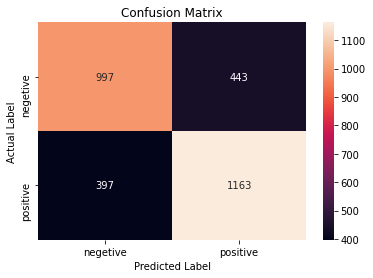

In [188]:
class_label=['negetive','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [189]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negetive       0.72      0.69      0.70      1440
    positive       0.72      0.75      0.73      1560

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000




# **Observations:**
 1) Optimal k is 39 accuracy is 73.93   
 2) From Confusion matrix, model predicted 1623 as positive & acutal postive are 1505 and predicted 1377 as negative & actual negative are 1495 which is quite good.     
 3) So we can say that, this model works well

## **WORD2VEC**

In [190]:
X= data['CleanText']
y=data['Score']
print(X.shape,y.shape)

(10000,) (10000,)


In [191]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=40)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [192]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [193]:
w2v_model= gensim.models.Word2Vec(list_of_sent,min_count=5,size=50,workers=4)
 

In [194]:
w2v_model.wv.most_similar('like')

[('realli', 0.9623720645904541),
 ('tast', 0.952036440372467),
 ('textur', 0.9386048913002014),
 ('pretti', 0.9382772445678711),
 ('spici', 0.9239088296890259),
 ('noth', 0.9209856986999512),
 ('smell', 0.9088646769523621),
 ('aftertast', 0.9064043164253235),
 ('real', 0.906173050403595),
 ('unappet', 0.9011863470077515)]

In [195]:
w2v=w2v_model[w2v_model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [145]:
w2v.shape

(3765, 50)

In [196]:
import gensim
list_of_sent_test = []
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [197]:
w2v_model=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [148]:
w2v_model.wv.most_similar('like')

[('tast', 0.998896598815918),
 ('sweet', 0.9988009333610535),
 ('flavor', 0.9987777471542358),
 ('smell', 0.9978070259094238),
 ('drink', 0.9977276921272278),
 ('good', 0.9974933862686157),
 ('realli', 0.9974045753479004),
 ('strong', 0.9972988367080688),
 ('chocol', 0.9967747926712036),
 ('bitter', 0.9965669512748718)]

In [198]:
w2v = w2v_model[w2v_model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


## AVG **W2V**

In [199]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


In [201]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
50


In [202]:

X_train=sent_vectors

In [203]:

X_test = sent_vectors_test


The optimal number of neighbors is 39.


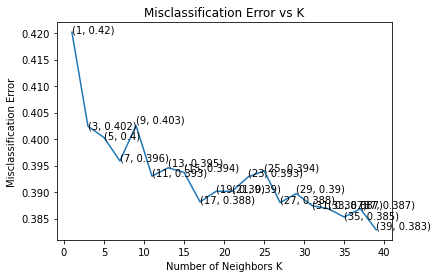

the misclassification error for each k value is :  [0.42  0.402 0.4   0.396 0.403 0.393 0.395 0.394 0.388 0.39  0.39  0.393
 0.394 0.388 0.39  0.387 0.387 0.385 0.387 0.383]


39

In [204]:

optimal_k_avgw2v = k_classifier_brute(X_train, y_train)
optimal_k_avgw2v

In [205]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v)

# fitting the model
knn_optimal.fit(X_train, y_train)

    
# predict the response
pred = knn_optimal.predict(X_test)

In [206]:
# Accuracy on train data
train_acc_avgw2v = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_avgw2v)

Train accuracy 0.6612857142857143


In [207]:
# Error on train data
train_err_avgw2v = 1-train_acc_avgw2v
print("Train Error %f%%" % (train_err_avgw2v))

Train Error 0.338714%


In [208]:
# evaluate accuracy
acc_avg_w2v = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_avgw2v, acc_avg_w2v))


The accuracy of the knn classifier for k = 39 is 60.833333%


In [209]:
print("Test Error %f%%" %(100-(acc_avg_w2v)))

Test Error 39.166667%


In [210]:
cm=confusion_matrix(y_test,pred)
cm

array([[960, 562],
       [613, 865]])

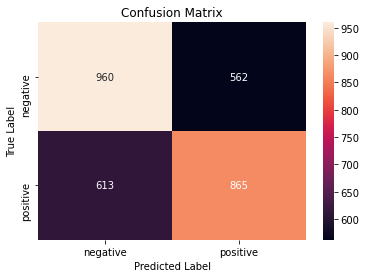

In [211]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [212]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negetive       0.61      0.63      0.62      1522
    positive       0.61      0.59      0.60      1478

    accuracy                           0.61      3000
   macro avg       0.61      0.61      0.61      3000
weighted avg       0.61      0.61      0.61      3000



# **Observations:**
 1) Optimal k is 19  
 2) Accuarcy if model is 59.766667%




## TF-IDF **W2V**

In [223]:
final_tf_idf = tf_idf_vec.fit_transform(data['CleanText'].values)
tfidf_feat = tf_idf_vec.get_feature_names()


tfidf_sent_vectors=[]
row=0
for sent in list_of_sent:
  sent_vec=np.zeros(50) # as word vectors are of zero length
  weighted_sum=0 

  for word in sent:
    try:
      vec=w2v_model.wv[word]
      tfidf= final_tf_idf[row,tfidf_feat.index(word)]
      sent_vec+=(vec*tfidf)
      weighted_sum+=tfidf
    except:
      pass
  sent_vec/=weighted_sum
  tfidf_sent_vectors.append(sent_vec)
  row+=1




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [224]:
len(tfidf_sent_vectors)

7000

In [282]:
X_train=tfidf_sent_vectors

In [283]:
tfidf_feat = tf_idf_vec.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = tf_idf_vec[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [284]:
print(len(tfidf_sent_vectors_test))
X_test=tfidf_sent_vectors_test

3000


In [ ]:
X_train

In [286]:
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

In [ ]:
X_train


The optimal number of neighbors is 33.


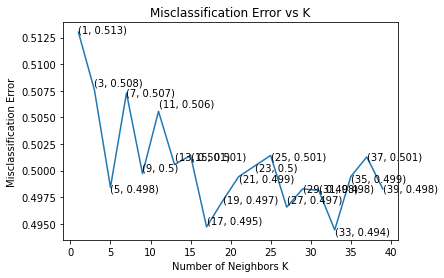

the misclassification error for each k value is :  [0.513 0.508 0.498 0.507 0.5   0.506 0.501 0.501 0.495 0.497 0.499 0.5
 0.501 0.497 0.498 0.498 0.494 0.499 0.501 0.498]


33

In [233]:

optimal_k_tfidf_w2v = k_classifier_brute(X_train, y_train)
optimal_k_tfidf_w2v

In [235]:
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k_tfidf_w2v)

#Fitting model

knn_optimal.fit(X_train,y_train)
#Predict the response

pred=knn_optimal.predict(X_test)

In [236]:
train_acc_tfidf_w2v=knn_optimal.score(X_train,y_train)
print('The accuracy is ',train_acc_tfidf_w2v)

The accuracy is  0.5444285714285715


In [237]:
train_err_tfidf_w2v = 1-train_acc_tfidf_w2v
print('Train error is {}'.format(train_err_tfidf_w2v))

Train error is 0.4555714285714285


In [241]:
#Evaluate accuracy

acc_tfidf_w2v=accuracy_score(y_test,pred)*100
print('The accuracy for knn classifer and k={}, accuracy={}'.format(optimal_k_tfidf_w2v, acc_tfidf_w2v))

The accuracy for knn classifer and k=33, accuracy=52.0


In [242]:
print('Test Error is {}'.format(100-(acc_tfidf_w2v)))

Test Error is 48.0


In [243]:
cm = confusion_matrix(y_test, pred)
cm

array([[   0, 1440],
       [   0, 1560]])

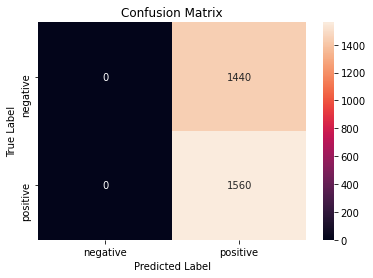

In [244]:

class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [245]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negetive       0.00      0.00      0.00      1440
    positive       0.52      1.00      0.68      1560

    accuracy                           0.52      3000
   macro avg       0.26      0.50      0.34      3000
weighted avg       0.27      0.52      0.36      3000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Observations: 


As we observed in confusion matrix that, 
model predicted all reviews on the basis of majority class. It is dull model to use.

In [277]:
# model
models = pd.DataFrame({'Model': ['KNN with Bow', "KNN with TFIDF", "KNN with Avg_w2v", "KNN with tfidf_w2v"], 
                       'Hyper Parameter(K)': [optimal_k_bow, optimal_k_tfidf, optimal_k_avgw2v, optimal_k_tfidf_w2v], 
                       'Train Error': [train_err_bow, train_err_tfidf, train_err_avgw2v, train_err_tfidf_w2v], 
                       'Test Error': [100-acc_bow, TFidfTest_error, 100-acc_avg_w2v, 100-acc_tfidf_w2v],
                       'Accuracy': [acc_bow, acc_tfidf, acc_avg_w2v, acc_tfidf_w2v]},
                       columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy
1,KNN with TFIDF,39,0.241571,0.280000,72.000000
0,KNN with Bow,39,0.253286,30.833333,69.166667
2,KNN with Avg_w2v,39,0.338714,39.166667,60.833333
3,KNN with tfidf_w2v,33,0.455571,48.000000,52.000000



## **Conclusion:**
As per above table, it is cleared that KNN with tf-IDF is quite good.